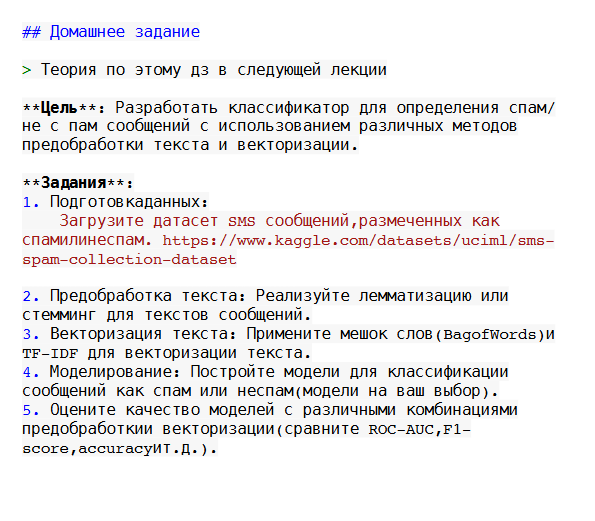

Импортируем библиотеки

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, f1_score
from sklearn.naive_bayes import MultinomialNB

Загрузим файл и выведем первые 5 строк

In [ ]:
data = pd.read_csv("spam.csv", encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Похоже, что столбцы Unnamed: 2,	Unnamed: 3 и	Unnamed: 4 не енсут в себе полезной информации, поэтому удалим их

In [ ]:
data = data[['v1', 'v2']]
data.columns = ['label', 'message']

Переименуем метки: 1 для спама и 0 для не спама

In [ ]:
data['label'] = data['label'].map({'spam': 1, 'ham': 0})

Выполним загрузку языковых ресурсов из библиотеки NLTK

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Получим список стоп-слов на английском языке и создадим лемматизатор

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

Напишем функцию для предварительной обработки текста

In [ ]:
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление всех, кроме букв и цифр
    text = re.sub(r'\W', ' ', text)
    # Токенизация
    words = nltk.word_tokenize(text)
    # Удаление стоп-слов и лемматизация
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

Предобработаем текст для каждого сообщени и выведем полученную таблицу

In [ ]:
data['clean_message'] = data['message'].apply(preprocess_text)
data.head()

,label,message,clean_message
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


Создаем векторизатор

In [ ]:
vectorizer_bow = CountVectorizer()

Применяем к тексту

In [ ]:
X_bow = vectorizer_bow.fit_transform(data['clean_message'])

Создаем TF-IDF векторизатор

In [ ]:
vectorizer_tfidf = TfidfVectorizer()

Применяем к текстам

In [ ]:
X_tfidf = vectorizer_tfidf.fit_transform(data['clean_message'])

Разделим данные на обучающую и тестовую выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, data['label'], test_size=0.2, random_state=42)

Создаем и обучаем модель

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

Сделаем предсказание

In [ ]:
y_pred = model.predict(X_test)

Теперь перейдем к другой модели, перед этим разделим данные:

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, data['label'], test_size=0.2, random_state=42)

Создаем и обучаем модель наивного байеса

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train_bow, y_train_bow)

MultinomialNB()

Сделаем предсказание

In [ ]:
y_pred_bow = nb_model.predict(X_test_bow)

Оценим качество модели

In [ ]:
print("Accuracy:", accuracy_score(y_test_bow, y_pred_bow))
print("ROC-AUC:", roc_auc_score(y_test_bow, y_pred_bow))
print(classification_report(y_test_bow, y_pred_bow))

Accuracy: 0.9766816143497757
ROC-AUC: 0.9527461139896373
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.91      0.92      0.91       150

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



Выедем сравнение:

In [ ]:
results = pd.DataFrame({
    'Model': ['Logistic Regression (TF-IDF)', 'Naive Bayes (Bag of Words)'],
    'Accuracy': [accuracy_score(y_test, y_pred), accuracy_score(y_test_bow, y_pred_bow)],
    'ROC-AUC': [roc_auc_score(y_test, y_pred), roc_auc_score(y_test_bow, y_pred_bow)],
    'F1-score': [f1_score(y_test, y_pred), f1_score(y_test_bow, y_pred_bow)]
})

print(results)

                          Model  Accuracy   ROC-AUC  F1-score
0  Logistic Regression (TF-IDF)  0.942601  0.800743  0.739837
1    Naive Bayes (Bag of Words)  0.976682  0.952746  0.913907


В целом, наивный байес на Bag of Words показал себя лучше.